## Fine-tuning BERT for Sentiment Analysis
[![Portfolio](https://img.shields.io/badge/Moritz_Pfeifer-Cineuropa_Project-blue?logo=GitHub)](https://github.com/Moritz-Pfeifer/Cineuropa-Project)

# A - Introduction

Add summary of project here

# B - Setup

## 1. Load Essential Libraries

In [1]:
import os
import re
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


%matplotlib inline

### 2.1. Upload Datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
path = '/content/drive/MyDrive/Cineuropa_Project/'
df = pd.read_csv(path+'reviews.csv')
df.head()

In [ ]:
df['cineuropa_review_text'] = df['cineuropa_review_text'].astype(str)
df['variety_review_text'] = df['variety_review_text'].astype(str)
df['hollywoodreporter_review_text'] = df['hollywoodreporter_review_text'].astype(str)
df['screendaily_review_text'] = df['screendaily_review_text'].astype(str)

### 2.2. Load Train Data
The train dataset is the [IMDB dataset](http://www.aclweb.org/anthology/P11-1015), a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. It contains a set of 25,000 highly polar movie reviews for training, and 25,000 for testing.

In [ ]:
 # Load IMDB data and set labels
data_imdb = pd.read_csv('/content/drive/MyDrive/Cineuropa_Project/IMDB_Dataset.csv')
data_imdb.sentiment.replace(['positive', 'negative'], [1, 0], inplace=True)

#Display 5 random samples
data_imdb.sample(5)

,review,sentiment
33553,I really liked this Summerslam due to the look...,1
9427,Not many television shows appeal to quite as m...,1
199,The film quickly gets to a major chase scene w...,0
12447,Jane Austen would definitely approve of this o...,1
39489,Expectations were somewhat high for me when I ...,0


Split data 127 top, 382 bottom

In [ ]:
def truncate_top_bottom(text):
  # naively splitting the text based on space
  text_tokens = text.split(' ')

  if len(text_tokens) > 509:
    top_text = text_tokens[0:127]
    bottom_text = text_tokens[len(text_tokens) - 382 - 1:-1]

    text = " ".join([str(item) for item in top_text]) + " " + " ".join([str(item) for item in bottom_text])

  return text

In [ ]:
data_imdb['review_truncate'] = data_imdb['review'].apply(lambda x: truncate_top_bottom(x))

The training data set is split into two sets: a train set with 90% of the data and a validation set with 10% of the data. Hyperparameter tuning is performed using cross-validation on the train set and use the validation set to compare models.

In [ ]:
from sklearn.model_selection import train_test_split

X = data_imdb.review_truncate.values
y = data_imdb.sentiment.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

### 2.3. Load Test Data
The test data contains 5760 examples with no label. The task is to identify whether they are positive or negative.

In [ ]:
# Test text data only
test_data_cineuropa = df[['cineuropa_review_text']]
test_data_variety =  df[['variety_review_text']]
test_data_hollywoodreporter =  df[['hollywoodreporter_review_text']]
test_data_screendaily =  df[['screendaily_review_text']]

Split data 127 top, 382 bottom.

In [ ]:
test_data_cineuropa['cineuropa_review_text_truncate'] = test_data_cineuropa['cineuropa_review_text'].apply(lambda x: truncate_top_bottom(x))
test_data_variety['variety_review_text_truncate'] = test_data_variety['variety_review_text'].apply(lambda x: truncate_top_bottom(x))
test_data_hollywoodreporter['hollywoodreporter_review_text_truncate'] = test_data_hollywoodreporter['hollywoodreporter_review_text'].apply(lambda x: truncate_top_bottom(x))
test_data_screendaily['screendaily_review_text_truncate'] = test_data_screendaily['screendaily_review_text'].apply(lambda x: truncate_top_bottom(x))

<ipython-input-61-c184e76dafb0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_cineuropa['cineuropa_review_text_truncate'] = test_data_cineuropa['cineuropa_review_text'].apply(lambda x: truncate_top_bottom(x))
<ipython-input-61-c184e76dafb0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_variety['variety_review_text_truncate'] = test_data_variety['variety_review_text'].apply(lambda x: truncate_top_bottom(x))
<ipython-input-61-c184e76dafb0>:3: SettingWithCopyWarning: 
A value is tryin

Let's split data on sentence level

In [ ]:
df['ID'] = range(1, len(df) + 1)
df

,ID,url,title,original_title,director,year,country,cineuropa_review_author,cineuropa_review_text,cineuropa_review_date,...,variety_review_text,variety_review_date,hollywoodreporter_review_author,hollywoodreporter_review_text,hollywoodreporter_review_date,screendaily_review_author,screendaily_review_text,screendaily_review_date,rottentomatoes_tomatometer_score,rottentomatoes_audience_score
0,1,https://www.cineuropa.org/en/newsdetail/431794/,The Innocent,L'Innocent,Louis Garrel,2022,France,Louis Garrel,Not all of Louis Garrel's films as a director ...,11/10/2022,...,nan,NaN,NaN,nan,NaN,NaN,\n\nSource: Wild Bunch International\n\n’The I...,25/05/2022,NaN,NaN
1,2,https://www.cineuropa.org/en/newsdetail/431796/,Venus,Venus,Jaume Balagueró,2022,Spain,Jaume Balagueró,"In her book Reina del grito, Spanish critic De...",11/10/2022,...,nan,NaN,NaN,nan,NaN,NaN,nan,NaN,NaN,NaN
2,3,https://www.cineuropa.org/en/newsdetail/431727/,Eagles from Țaga,Vulturii din Țaga,"Iulian Manuel Ghervas, Adina Popescu",2022,"Romania, Slovakia","Iulian Manuel Ghervas, Adina Popescu",After making its international debut in August...,10/10/2022,...,nan,NaN,NaN,nan,NaN,NaN,nan,NaN,NaN,NaN
3,4,https://www.cineuropa.org/en/newsdetail/431679/,Amazing Elisa,Asombrosa Elisa,Sadrac González-Perellón,2022,Spain,Sadrac González-Perellón,In Amazing Elisa [+see also: trailerfilm profi...,07/10/2022,...,nan,NaN,NaN,nan,NaN,NaN,nan,NaN,NaN,NaN
4,5,https://www.cineuropa.org/en/newsdetail/431691/,Roald Dahl's Matilda the Musical,Roald Dahl's Matilda the Musical,Matthew Warchus,2022,"United Kingdom, United States",Matthew Warchus,When you go to see a modern Marvel Comics adap...,07/10/2022,...,What children love about Roald Dahl's books is...,05/10/2022,NaN,nan,NaN,NaN,nan,NaN,100.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,5756,https://www.cineuropa.org/en/newsdetail/51224/,Live and Become,"Va, vis et deviens",Radu Mihaileanu,2005,"France, Italy, Israel, Belgium",Radu Mihaileanu,"""Cry now, if you want"". These words, uttered r...",06/04/2005,...,Constructed from sturdy dramatic elements but ...,14/02/2005,NaN,nan,NaN,Dan Fainaru,Dir.Radu Mihaileanu. Fr-Is-It-Bel. 2005. 153mi...,30/03/2005,88.0,93.0
5756,5757,https://www.cineuropa.org/en/newsdetail/51042/,I Like to Work (Mobbing),Mi piace lavorare,Francesca Comencini,2004,Italy,Francesca Comencini,"Neons, impersonal corridors, small stall-offic...",23/03/2005,...,A quiet drama about the insidious effects of h...,22/02/2004,NaN,nan,NaN,NaN,nan,NaN,NaN,NaN
5757,5758,https://www.cineuropa.org/en/newsdetail/50941/,ANDRE VALENTE,ANDRE VALENTE,Catarina Ruivo,2004,Portugal,Catarina Ruivo,Catarina Ruivo’s André Valente [+see also: tra...,16/03/2005,...,The world probably doesn't really need another...,17/08/2004,NaN,nan,NaN,NaN,nan,NaN,NaN,NaN
5758,5759,https://www.cineuropa.org/en/newsdetail/50939/,Hotel Rwanda,Hotel Rwanda,Terry George,2004,"United Kingdom, Canada, Italy, Saudi Arabia",Terry George,'While everybody in the world had their eyes s...,16/03/2005,...,The genocide of some one million Rwandan Tutsi...,15/09/2004,NaN,nan,NaN,Jacob Neiiendam,Dir: Terry George. 2004.S Afr-UK-It. 122mins.\...,20/09/2004,91.0,94.0


In [ ]:
df.columns

Index(['ID', 'url', 'title', 'original_title', 'director', 'year', 'country',
       'cineuropa_review_author', 'cineuropa_review_text',
       'cineuropa_review_date', 'variety_review_author', 'variety_review_text',
       'variety_review_date', 'hollywoodreporter_review_author',
       'hollywoodreporter_review_text', 'hollywoodreporter_review_date',
       'screendaily_review_author', 'screendaily_review_text',
       'screendaily_review_date', 'rottentomatoes_tomatometer_score',
       'rottentomatoes_audience_score'],
      dtype='object')

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
text = df['screendaily_review_text']
text = text.astype("string")
text.head(50)

,screendaily_review_text
0,Source: Wild Bunch International ’The Innoc...
1,nan
2,nan
3,nan
4,nan
5,nan
6,nan
7,nan
8,nan
9,nan


In [ ]:
def tokenize_and_create_df(row):
    text = row['screendaily_review_text']
    if pd.notna(text) and isinstance(text, str):
        sentences = sent_tokenize(text)
        new_df_parsed_intermediate = pd.DataFrame(sentences, columns=["screendaily_review_text"])
        new_df_parsed_intermediate["year"] = row["year"]
        new_df_parsed_intermediate["screendaily_review_date"] = row["screendaily_review_date"]
        new_df_parsed_intermediate["title"] = row["title"]
        new_df_parsed_intermediate["original_title"] = row["original_title"]
        new_df_parsed_intermediate["country"] = row["country"]
        new_df_parsed_intermediate["ID"] = row["ID"]
        return new_df_parsed_intermediate
    else:
        return pd.DataFrame()

In [ ]:
new_df_parsed = pd.concat(df.apply(tokenize_and_create_df, axis=1).tolist(), ignore_index=True, sort=False)
new_df_parsed

,screendaily_review_text,year,screendaily_review_date,title,original_title,country,ID
0,\n\nSource: Wild Bunch International\n\n’The I...,2022,25/05/2022,The Innocent,L'Innocent,France,1
1,France.,2022,25/05/2022,The Innocent,L'Innocent,France,1
2,2022.,2022,25/05/2022,The Innocent,L'Innocent,France,1
3,99 mins.,2022,25/05/2022,The Innocent,L'Innocent,France,1
4,The crime-comedy-romance The Innocent stars di...,2022,25/05/2022,The Innocent,L'Innocent,France,1
...,...,...,...,...,...,...,...
52722,Georgealso chooses not to point fingers and ma...,2004,20/09/2004,Hotel Rwanda,Hotel Rwanda,"United Kingdom, Canada, Italy, Saudi Arabia",5759
52723,"Don Cheadle, in his firstlead, gives a solid p...",2004,20/09/2004,Hotel Rwanda,Hotel Rwanda,"United Kingdom, Canada, Italy, Saudi Arabia",5759
52724,"He is well supported bythe rest of the cast, w...",2004,20/09/2004,Hotel Rwanda,Hotel Rwanda,"United Kingdom, Canada, Italy, Saudi Arabia",5759
52725,"Prod cos: Miracle Pictures, Seamus Prods, Unit...",2004,20/09/2004,Hotel Rwanda,Hotel Rwanda,"United Kingdom, Canada, Italy, Saudi Arabia",5759


## 3. Set up GPU for training

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

`Runtime -> Change runtime type -> Hardware accelerator: GPU`

Then we need to run the following cell to specify the GPU as the device.

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# C - Fine-tuning BERT

The model predicts two possible sentiment values for each input sentence:

> 0: Negative <br>
> 1: Positive


We will fine-tune a BERT model. BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the `[CLS]` token is used as the features of the sequence to feed a classifier.

The `transformers` library has the [`BertForSequenceClassification`](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification) class which is designed for classification tasks.

To use a more powerful model replace `bert-base-uncased` by `bert-large-uncased` in following code.


In [ ]:
!pip install transformers[torch]
!pip install accelerate -U
# restart session after installation

In [ ]:
import warnings
import sklearn.exceptions
from transformers import DataCollatorWithPadding, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import default_data_collator
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
warnings.filterwarnings('ignore', category=sklearn.exceptions.UndefinedMetricWarning)
path

'/content/drive/MyDrive/Cineuropa_Project/'

In [ ]:
from scipy.special import softmax

def test_model(model, tokenizer, X_test, y_test):
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)
    test_dataset = SentimentDataset(test_encodings, y_test)

    # Set up the data collator to avoid padding the labels
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Set up the trainer with the test data
    trainer = Trainer(model=model, data_collator=data_collator)

    # Make predictions on the test set
    predictions = trainer.predict(test_dataset=test_dataset).predictions.argmax(axis=1)

    # Make predictions on the test set
    predictions_prob = trainer.predict(test_dataset=test_dataset).predictions[:, 1]

    # Return the true and predicted labels
    return y_test, predictions, predictions_prob

In [ ]:
from scipy.special import softmax

def predict_sentiment(model, tokenizer, X_test):
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)
    y_test = [1] * len(list(X_test))
    test_dataset = SentimentDataset(test_encodings, y_test)

    # Set up the data collator to avoid padding the labels
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Set up the trainer with the test data
    trainer = Trainer(model=model, data_collator=data_collator)

    # Make predictions on the test set
    predictions = trainer.predict(test_dataset=test_dataset).predictions.argmax(axis=1)

    # Make predictions on the test set
    predictions_prob = trainer.predict(test_dataset=test_dataset).predictions

    # Return the true and predicted labels
    return predictions, predictions_prob

In order to achieve optimal resultas, we can change the hyper-parameters, e.g.:

- Batch size: 16 or 32
- Learning rate: 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

In [ ]:
# Create a Dataset object from the encodings
class SentimentDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

def show_evaluation_results(y_true, y_pred, y_pred_proba):
    print('Classification Report:')
    print(classification_report(y_true, y_pred))

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(15,4))
    plt.subplot(131)
    lw = 2
    plt.plot(fpr, tpr, color='lightsteelblue', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    ax1 = plt.subplot(132)
    sns.heatmap(cm, annot=True, ax=ax1, cmap='Blues', fmt='g')
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax1.yaxis.set_ticklabels(['Negative', 'Positive'])

def compute_metrics(p):
    y_true = p.label_ids
    y_pred = p.predictions.argmax(axis=-1)
    try:
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    except:
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    acc = accuracy_score(y_true, y_pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def show_validation_loss(val_losses, training_loss_values):
    # Plot validation loss
    ax2 = plt.subplot(133)
    plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss')
    plt.plot(np.arange(len(training_loss_values)), training_loss_values, label='Training Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training vs Validation Loss')
    plt.legend(loc='upper right')
    plt.tight_layout();


def train_model(model, tokenizer, X_train, y_train, X_test, y_test, epochs=3, batch_size=16, max_length=512, learning_rate=2e-5, modelName="", gradient_accumulation_steps=1):

    # Tokenize the training data
    train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=max_length)
    train_dataset = SentimentDataset(train_encodings, y_train)
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_length)
    test_dataset = SentimentDataset(test_encodings, y_test)

    # Define the training arguments
    training_args = TrainingArguments(
        output_dir=modelName,          # output directory
        num_train_epochs=epochs,          # total number of training epochs
        per_device_train_batch_size=batch_size,  # batch size per device during training
        per_device_eval_batch_size=batch_size,   # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        learning_rate=learning_rate,
        logging_steps=10,
        evaluation_strategy='epoch',
        save_total_limit=1,
        gradient_accumulation_steps=gradient_accumulation_steps
    )

    # Define the trainer
    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=test_dataset,
      data_collator=default_data_collator,
      compute_metrics=compute_metrics
      )

    # Train the model
    trainer.train()

    eval_loss_values = []
    training_loss_values = []
    tr_loss_value = None
    for i in trainer.state.log_history:
        try:
            eval_loss_values.append(i['eval_loss'])
            training_loss_values.append(tr_loss_value)
        except:
            pass

        try:
            tr_loss_value = i['loss']
        except:
            pass

    # Return the trained model and tokenizer
    return model, tokenizer, eval_loss_values, training_loss_values

In [ ]:
# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model_name = 'BERT' # name for saving

# Train the model
model, tokenizer, val_losses, training_loss_values = train_model(model, tokenizer, X_train, y_train, X_val, y_val, epochs=4, batch_size = 16, learning_rate=1e-6, modelName=path+'result/'+model_name)

# Test the model
y_true, y_pred, y_pred_prob = test_model(model, tokenizer, X_val, y_val)

# Print the classification report
# plot/ show evaluation
show_evaluation_results(y_true, y_pred, y_pred_prob)

show_validation_loss(val_losses, training_loss_values)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

# D - Load Model

In [ ]:
def load_model_from_checkpoint(checkpoint, which_model):
    # initialize tokenizer and model class
    tokenizer = BertTokenizer.from_pretrained(which_model)
    model = BertForSequenceClassification.from_pretrained(checkpoint)
    # Return the loaded model and tokenizer
    return model, tokenizer

In [ ]:
checkpoint = glob.glob(path+'/result/'+'*BERT*/*checkpoint*')[0]

In [ ]:
model_from_memory, tokenizer_from_memory = load_model_from_checkpoint(checkpoint, 'bert-base-uncased')

# F - Label Data Sets

In [ ]:
import tensorflow as tf

def find_sentiment_reviews(reviews):

    if type(reviews) is list:
        reviews_df = pd.DataFrame()
        reviews_df['text'] = reviews
    else:
        reviews_df = reviews

    predicted_values = predict_sentiment(model_from_memory, tokenizer_from_memory, reviews_df["text"].values.tolist())
    reviews_df['Predicted Sentiment'] = predicted_values[0]
    reviews_df['Sentiment (Probabilities)'] = None
    reviews_df['Sentiment (Probabilities)'] = reviews_df['Sentiment (Probabilities)'].astype('object')
    reviews_df['Sentiment (Probabilities)'] =  [predicted_values[1][i, :] for i in range(len(reviews_df))]
    reviews_df['Sentiment (Probabilities)'] = reviews_df['Sentiment (Probabilities)'].apply(lambda x: tf.nn.softmax(x))

    return reviews_df

Let's label the Cineuropa data set (and the other data sets)

In [ ]:
# Determine what data we want to label
input_list = test_data_screendaily['screendaily_review_text_truncate'].values.tolist()
'''
replace with:
test_data_variety['variety_review_text_truncate']
test_data_hollywoodreporter['hollywoodreporter_review_text_truncate']
test_data_screendaily['screendaily_review_text_truncate']
'''
# Convert all elements into strings so that we may label:
converted_list = [str(element) for element in input_list]

# Splitting the list so we can do it in batches
part_size = len(converted_list) // 10  # Calculate the size of each part

split_list = [converted_list[i:i+part_size] for i in range(0, len(converted_list), part_size)]

# Print each part separately
for i, part in enumerate(split_list):
    print(f"Part {i+1}: {part}")

In [ ]:
results_screendaily = find_sentiment_reviews(converted_list)

In [ ]:
# Intermediate save:
results_screendaily.to_csv(path+'Model_Output/Screendaily_labelled.csv')

# G - RoBERTa

Let's try RoBERTa

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
import tensorflow as tf

def find_sentiment_reviews(reviews):

    if type(reviews) is list:
        reviews_df = pd.DataFrame()
        reviews_df['text'] = reviews
    else:
        reviews_df = reviews

    predicted_values = predict_sentiment(model, tokenizer, reviews_df["text"].values.tolist())
    reviews_df['Predicted Sentiment'] = predicted_values[0]
    reviews_df['Sentiment (Probabilities)'] = None
    reviews_df['Sentiment (Probabilities)'] = reviews_df['Sentiment (Probabilities)'].astype('object')
    reviews_df['Sentiment (Probabilities)'] =  [predicted_values[1][i, :] for i in range(len(reviews_df))]
    reviews_df['Sentiment (Probabilities)'] = reviews_df['Sentiment (Probabilities)'].apply(lambda x: tf.nn.softmax(x))

    return reviews_df

In [ ]:
reviews_df = pd.DataFrame()
reviews_df['text']

KeyError: 'text'

In [ ]:
# Determine what data we want to label
input_list = new_df_parsed['screendaily_review_text'].values.tolist()
'''
replace with:
test_data_cineuropa['cineuropa_review_text']
test_data_variety['variety_review_text_truncate']
test_data_hollywoodreporter['hollywoodreporter_review_text_truncate']
test_data_screendaily['screendaily_review_text_truncate']
'''
# Convert all elements into strings so that we may label:
converted_list = [str(element) for element in input_list]

# Splitting the list so we can do it in batches
part_size = len(converted_list) // 10  # Calculate the size of each part

split_list = [converted_list[i:i+part_size] for i in range(0, len(converted_list), part_size)]

# Print each part separately
for i, part in enumerate(split_list):
    print(f"Part {i+1}: {part}")

In [ ]:
screendaily_reviews = find_sentiment_reviews(converted_list)

In [ ]:
screendaily_reviews

In [ ]:
screendaily_reviews.to_csv(path+'Model_Output/Screendaily_reviews.csv')

In [ ]:
new_df_parsed

In [ ]:
data_all = pd.concat([screendaily_reviews, new_df_parsed], axis=1)
data_all.to_csv(path+'Model_Output/Screendaily_reviews.csv')

In [ ]:
test = pd.read_csv(path+'Model_Output/Hollywoodreporter_reviews.csv')
test

,Unnamed: 0,text,Predicted Sentiment,Sentiment (Probabilities),hollywoodreporter_review_text,year,hollywoodreporter_review_date,title,original_title,country,ID
0,0,NaN,0,"tf.Tensor([0.83475655 0.16524342], shape=(2,),...",NaN,2022,NaN,The Innocent,L'Innocent,France,1
1,1,NaN,0,"tf.Tensor([0.83475655 0.16524342], shape=(2,),...",NaN,2022,NaN,Venus,Venus,Spain,2
2,2,NaN,0,"tf.Tensor([0.83475655 0.16524342], shape=(2,),...",NaN,2022,NaN,Eagles from Țaga,Vulturii din Țaga,"Romania, Slovakia",3
3,3,NaN,0,"tf.Tensor([0.83475655 0.16524342], shape=(2,),...",NaN,2022,NaN,Amazing Elisa,Asombrosa Elisa,Spain,4
4,4,NaN,0,"tf.Tensor([0.83475655 0.16524342], shape=(2,),...",NaN,2022,NaN,Roald Dahl's Matilda the Musical,Roald Dahl's Matilda the Musical,"United Kingdom, United States",5
...,...,...,...,...,...,...,...,...,...,...,...
51221,51221,NaN,0,"tf.Tensor([0.83475655 0.16524342], shape=(2,),...",NaN,2005,NaN,Live and Become,"Va, vis et deviens","France, Italy, Israel, Belgium",5756
51222,51222,NaN,0,"tf.Tensor([0.83475655 0.16524342], shape=(2,),...",NaN,2004,NaN,I Like to Work (Mobbing),Mi piace lavorare,Italy,5757
51223,51223,NaN,0,"tf.Tensor([0.83475655 0.16524342], shape=(2,),...",NaN,2004,NaN,ANDRE VALENTE,ANDRE VALENTE,Portugal,5758
51224,51224,NaN,0,"tf.Tensor([0.8347635 0.16523647], shape=(2,),...",NaN,2004,NaN,Hotel Rwanda,Hotel Rwanda,"United Kingdom, Canada, Italy, Saudi Arabia",5759


# H - Analyse Results BERT

In [ ]:
cineuropa = pd.read_csv(path+'Model_Output/Cineuropa_labelled.csv', index_col='Unnamed: 0')
variety = pd.read_csv(path+'Model_Output/Variety_labelled.csv', index_col='Unnamed: 0')
hollywoodreporter = pd.read_csv(path+'Model_Output/Hollywoodreporter_labelled.csv', index_col='Unnamed: 0')
screendaily = pd.read_csv(path+'Model_Output/Screendaily_labelled.csv', index_col='Unnamed: 0')

In [ ]:
cineuropa.rename(columns={'Predicted Sentiment': 'Predicted Sentiment Cineuropa',
                          'Sentiment (Probabilities)': 'Sentiment (Probabilities) Cineuropa'}, inplace=True)

variety.rename(columns={'Predicted Sentiment': 'Predicted Sentiment Variety',
                          'Sentiment (Probabilities)': 'Sentiment (Probabilities) Variety'}, inplace=True)

hollywoodreporter.rename(columns={'Predicted Sentiment': 'Predicted Sentiment Hollywoodreporter',
                          'Sentiment (Probabilities)': 'Sentiment (Probabilities) Hollywoodreporter'}, inplace=True)

screendaily.rename(columns={'Predicted Sentiment': 'Predicted Sentiment Screendaily',
                          'Sentiment (Probabilities)': 'Sentiment (Probabilities) Screendaily'}, inplace=True)

In [ ]:
# Replace Probits of NaNs with NaNs
cineuropa['Predicted Sentiment Cineuropa'].loc[cineuropa['text'].isna()] = np.nan
cineuropa['Sentiment (Probabilities) Cineuropa'].loc[cineuropa['text'].isna()] = np.nan

variety['Predicted Sentiment Variety'].loc[variety['text'].isna()] = np.nan
variety['Sentiment (Probabilities) Variety'].loc[variety['text'].isna()] = np.nan

hollywoodreporter['Predicted Sentiment Hollywoodreporter'].loc[hollywoodreporter['text'].isna()] = np.nan
hollywoodreporter['Sentiment (Probabilities) Hollywoodreporter'].loc[hollywoodreporter['text'].isna()] = np.nan

screendaily['Predicted Sentiment Screendaily'].loc[screendaily['text'].isna()] = np.nan
screendaily['Sentiment (Probabilities) Screendaily'].loc[screendaily['text'].isna()] = np.nan

In [ ]:
data_all = pd.concat([cineuropa,
                      variety,
                      hollywoodreporter,
                      screendaily,
                      df
                      ], axis=1)
data_all['cineuropa_review_date'] = pd.to_datetime(data_all['cineuropa_review_date'], format='%d/%m/%Y')
data_all['cineuropa_quarter'] = data_all['cineuropa_review_date'].dt.to_period('Q')
#data_all['cineuropa_quarter'] = data_all['cineuropa_quarter'].dt.to_timestamp().dt.strftime('%d/%m/%Y')
data_all['variety_review_date'] = pd.to_datetime(data_all['variety_review_date'], format='%d/%m/%Y')
data_all['variety_quarter'] = data_all['variety_review_date'].dt.to_period('Q')
#data_all['variety_quarter'] = data_all['variety_quarter'].dt.to_timestamp().dt.strftime('%d/%m/%Y')
data_all['hollywoodreporter_review_date'] = pd.to_datetime(data_all['hollywoodreporter_review_date'], format='%d/%m/%Y')
data_all['hollywoodreporter_quarter'] = data_all['hollywoodreporter_review_date'].dt.to_period('Q')
#data_all['hollywoodreporter_quarter'] = data_all['hollywoodreporter_quarter'].dt.to_timestamp().dt.strftime('%d/%m/%Y')
data_all['screendaily_review_date'] = pd.to_datetime(data_all['screendaily_review_date'], format='%d/%m/%Y')
data_all['screendaily_quarter'] = data_all['screendaily_review_date'].dt.to_period('Q')
#data_all['screendaily_quarter'] = data_all['screendaily_quarter'].dt.to_timestamp().dt.strftime('%d/%m/%Y')

In [ ]:
# Clean tensforflow probits
data_all['Sentiment (Probabilities) Cineuropa'] = data_all['Sentiment (Probabilities) Cineuropa'].apply(
    lambda x: re.findall(r'\d+\.\d+', x))
data_all['Sentiment (Probabilities) Cineuropa'] = data_all['Sentiment (Probabilities) Cineuropa'].apply(
    lambda x: [float(p) for p in x])

data_all['Sentiment (Probabilities) Variety'] = data_all['Sentiment (Probabilities) Variety'].apply(
    lambda x: re.findall(r'\d+\.\d+', x) if pd.notna(x) else np.nan)
data_all['Sentiment (Probabilities) Variety'] = data_all['Sentiment (Probabilities) Variety'].apply(
    lambda x : pd.to_numeric(x))

data_all['Sentiment (Probabilities) Hollywoodreporter'] = data_all['Sentiment (Probabilities) Hollywoodreporter'].apply(
    lambda x: re.findall(r'\d+\.\d+', x) if pd.notna(x) else np.nan)
data_all['Sentiment (Probabilities) Hollywoodreporter'] = data_all['Sentiment (Probabilities) Hollywoodreporter'].apply(
    lambda x : pd.to_numeric(x))

data_all['Sentiment (Probabilities) Screendaily'] = data_all['Sentiment (Probabilities) Screendaily'].apply(
    lambda x: re.findall(r'\d+\.\d+', x) if pd.notna(x) else np.nan)
data_all['Sentiment (Probabilities) Hollywoodreporter'] = data_all['Sentiment (Probabilities) Hollywoodreporter'].apply(
    lambda x : pd.to_numeric(x))

In [ ]:
mean_cineuropa = data_all.groupby('cineuropa_quarter')['Predicted Sentiment Cineuropa'].mean().reset_index()
mean_variety = data_all.groupby('variety_quarter')['Predicted Sentiment Variety'].mean().reset_index()
mean_hollywoodreporter = data_all.groupby('hollywoodreporter_quarter')['Predicted Sentiment Hollywoodreporter'].mean().reset_index()
mean_screenfaily = data_all.groupby('screendaily_quarter')['Predicted Sentiment Screendaily'].mean().reset_index()


In [ ]:
merged_data = mean_cineuropa.merge(mean_variety, left_on='cineuropa_quarter', right_on='variety_quarter', how='outer')
merged_data = merged_data.merge(mean_hollywoodreporter, left_on='cineuropa_quarter', right_on='hollywoodreporter_quarter', how='outer')
merged_data = merged_data.merge(mean_screenfaily, left_on='cineuropa_quarter', right_on='screendaily_quarter', how='outer')
merged_data = merged_data[['cineuropa_quarter',
                'Predicted Sentiment Cineuropa',
                'Predicted Sentiment Variety',
                'Predicted Sentiment Hollywoodreporter',
                'Predicted Sentiment Screendaily']]
merged_data['cineuropa_quarter'] = merged_data['cineuropa_quarter'].dt.to_timestamp().dt.strftime('%d/%m/%Y')
merged_data = merged_data[16:72]

In [ ]:
merged_data.describe()

,Predicted Sentiment Cineuropa,Predicted Sentiment Variety,Predicted Sentiment Hollywoodreporter,Predicted Sentiment Screendaily
count,56.000000,56.000000,53.000000,56.000000
mean,0.972035,0.809019,0.860139,0.922318
std,0.024661,0.090205,0.075998,0.055646
min,0.896552,0.590909,0.692308,0.750000
25%,0.959040,0.750000,0.809524,0.899444
50%,0.974209,0.802778,0.862069,0.922476
75%,0.991648,0.876838,0.914286,0.954960
max,1.000000,1.000000,1.000000,1.000000


In [ ]:
fig = px.line(title='Mean Sentiment Scores Over Time')
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Predicted Sentiment Cineuropa'],
                mode='lines', name='Cineuropa')
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Predicted Sentiment Variety'],
                mode='lines', name='Variety')
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Predicted Sentiment Hollywoodreporter'],
                mode='lines', name='Hollywood Reporter')
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Predicted Sentiment Screendaily'],
                mode='lines', name='Screen Daily')

fig.update_layout(yaxis_title='Mean Sentiment Score')
fig.update_yaxes(range=[0.6, 1.01])

fig.show()

# I - Analyse Results RoBERTa

In [ ]:
cineuropa = pd.read_csv(path+'Model_Output/RoBERTa_Cineuropa_labelled.csv', index_col='Unnamed: 0')
variety = pd.read_csv(path+'Model_Output/RoBERTa_Variety_labelled.csv', index_col='Unnamed: 0')
hollywoodreporter = pd.read_csv(path+'Model_Output/RoBERTa_Hollywoodreporter_labelled.csv', index_col='Unnamed: 0')
screendaily = pd.read_csv(path+'Model_Output/RoBERTa_Screendaily_labelled.csv', index_col='Unnamed: 0')

In [ ]:
def rename_columns(df, source_name):
    df.rename(columns={'Predicted Sentiment': f'Predicted Sentiment {source_name}',
                       'Sentiment (Probabilities)': f'Sentiment (Probabilities) {source_name}'}, inplace=True)

rename_columns(cineuropa, 'Cineuropa')
rename_columns(variety, 'Variety')
rename_columns(hollywoodreporter, 'Hollywoodreporter')
rename_columns(screendaily, 'Screendaily')

In [ ]:
def replace_na_with_nan(df, source_name):
    df[f'Predicted Sentiment {source_name}'].loc[df['text'].isna()] = np.nan
    df[f'Sentiment (Probabilities) {source_name}'].loc[df['text'].isna()] = np.nan

# Apply the function to each DataFrame
replace_na_with_nan(cineuropa, 'Cineuropa')
replace_na_with_nan(variety, 'Variety')
replace_na_with_nan(hollywoodreporter, 'Hollywoodreporter')
replace_na_with_nan(screendaily, 'Screendaily')

<ipython-input-8-506603c3b72a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'Predicted Sentiment {source_name}'].loc[df['text'].isna()] = np.nan
<ipython-input-8-506603c3b72a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'Sentiment (Probabilities) {source_name}'].loc[df['text'].isna()] = np.nan


In [ ]:
print(cineuropa.info())
print(variety.info())
print(hollywoodreporter.info())
print(screendaily.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5760 entries, 0 to 5759
Data columns (total 3 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   text                                 5760 non-null   object 
 1   Predicted Sentiment Cineuropa        5760 non-null   float64
 2   Sentiment (Probabilities) Cineuropa  5760 non-null   object 
dtypes: float64(1), object(2)
memory usage: 180.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5760 entries, 0 to 5759
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   text                               2082 non-null   object 
 1   Predicted Sentiment Variety        2082 non-null   float64
 2   Sentiment (Probabilities) Variety  2082 non-null   object 
dtypes: float64(1), object(2)
memory usage: 180.0+ KB
None
<class 'pandas.core.

In [ ]:
data_all = pd.concat([cineuropa,
                      variety,
                      hollywoodreporter,
                      screendaily,
                      df
                      ], axis=1)
data_all['cineuropa_review_date'] = pd.to_datetime(data_all['cineuropa_review_date'], format='%d/%m/%Y')
data_all['cineuropa_quarter'] = data_all['cineuropa_review_date'].dt.to_period('Q')

data_all['variety_review_date'] = pd.to_datetime(data_all['variety_review_date'], format='%d/%m/%Y')
data_all['variety_quarter'] = data_all['variety_review_date'].dt.to_period('Q')

data_all['hollywoodreporter_review_date'] = pd.to_datetime(data_all['hollywoodreporter_review_date'], format='%d/%m/%Y')
data_all['hollywoodreporter_quarter'] = data_all['hollywoodreporter_review_date'].dt.to_period('Q')

data_all['screendaily_review_date'] = pd.to_datetime(data_all['screendaily_review_date'], format='%d/%m/%Y')
data_all['screendaily_quarter'] = data_all['screendaily_review_date'].dt.to_period('Q')

In [ ]:
# Clean tensforflow probits
data_all['Sentiment (Probabilities) Cineuropa'] = data_all['Sentiment (Probabilities) Cineuropa'].apply(
    lambda x: re.findall(r'\d+\.\d+', x))
data_all['Sentiment (Probabilities) Cineuropa'] = data_all['Sentiment (Probabilities) Cineuropa'].apply(
    lambda x: [float(p) for p in x])

data_all['Sentiment (Probabilities) Variety'] = data_all['Sentiment (Probabilities) Variety'].apply(
    lambda x: re.findall(r'\d+\.\d+', x) if pd.notna(x) else np.nan)
data_all['Sentiment (Probabilities) Variety'] = data_all['Sentiment (Probabilities) Variety'].apply(
    lambda x : pd.to_numeric(x))

data_all['Sentiment (Probabilities) Hollywoodreporter'] = data_all['Sentiment (Probabilities) Hollywoodreporter'].apply(
    lambda x: re.findall(r'\d+\.\d+', x) if pd.notna(x) else np.nan)
data_all['Sentiment (Probabilities) Hollywoodreporter'] = data_all['Sentiment (Probabilities) Hollywoodreporter'].apply(
    lambda x : pd.to_numeric(x))

data_all['Sentiment (Probabilities) Screendaily'] = data_all['Sentiment (Probabilities) Screendaily'].apply(
    lambda x: re.findall(r'\d+\.\d+', x) if pd.notna(x) else np.nan)
data_all['Sentiment (Probabilities) Screendaily'] = data_all['Sentiment (Probabilities) Screendaily'].apply(
    lambda x : pd.to_numeric(x))

In [ ]:
mean_cineuropa = data_all.groupby('cineuropa_quarter')['Predicted Sentiment Cineuropa'].mean().reset_index()
mean_variety = data_all.groupby('variety_quarter')['Predicted Sentiment Variety'].mean().reset_index()
mean_hollywoodreporter = data_all.groupby('hollywoodreporter_quarter')['Predicted Sentiment Hollywoodreporter'].mean().reset_index()
mean_screenfaily = data_all.groupby('screendaily_quarter')['Predicted Sentiment Screendaily'].mean().reset_index()
mean_audience = data_all.groupby('cineuropa_quarter')['rottentomatoes_audience_score'].mean().reset_index()
mean_audience['rottentomatoes_audience_score'] = mean_audience['rottentomatoes_audience_score']  / 100
mean_meter = data_all.groupby('cineuropa_quarter')['rottentomatoes_tomatometer_score'].mean().reset_index()
mean_meter['rottentomatoes_tomatometer_score'] = mean_meter['rottentomatoes_tomatometer_score']  / 100

In [ ]:
merged_data = mean_cineuropa.merge(mean_variety, left_on='cineuropa_quarter', right_on='variety_quarter', how='outer')
merged_data = merged_data.merge(mean_hollywoodreporter, left_on='cineuropa_quarter', right_on='hollywoodreporter_quarter', how='outer')
merged_data = merged_data.merge(mean_screenfaily, left_on='cineuropa_quarter', right_on='screendaily_quarter', how='outer')
merged_data = merged_data.merge(mean_audience, left_on='cineuropa_quarter', right_on='cineuropa_quarter', how='outer')
merged_data = merged_data.merge(mean_meter, left_on='cineuropa_quarter', right_on='cineuropa_quarter', how='outer')


merged_data = merged_data[['cineuropa_quarter',
                'Predicted Sentiment Cineuropa',
                'Predicted Sentiment Variety',
                'Predicted Sentiment Hollywoodreporter',
                'Predicted Sentiment Screendaily',
                'rottentomatoes_audience_score',
                'rottentomatoes_tomatometer_score']]
merged_data['cineuropa_quarter'] = merged_data['cineuropa_quarter'].dt.to_timestamp().dt.strftime('%d/%m/%Y')
merged_data = merged_data[16:72]

In [ ]:
fig = px.line(title='Mean Sentiment Scores Over Time')
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Predicted Sentiment Cineuropa'],
                mode='lines', name='Cineuropa')
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Predicted Sentiment Variety'],
                mode='lines', name='Variety')
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Predicted Sentiment Hollywoodreporter'],
                mode='lines', name='Hollywood Reporter')
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Predicted Sentiment Screendaily'],
                mode='lines', name='Screen Daily')
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['rottentomatoes_audience_score'],
                mode='lines', name='Rotten Tomatoes Audience')
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['rottentomatoes_tomatometer_score'],
                mode='lines', name='Rotten Tomatoes Meta')

fig.update_layout(yaxis_title='Mean Sentiment Score')
fig.update_yaxes(range=[0.4, 1.01])

fig.show()

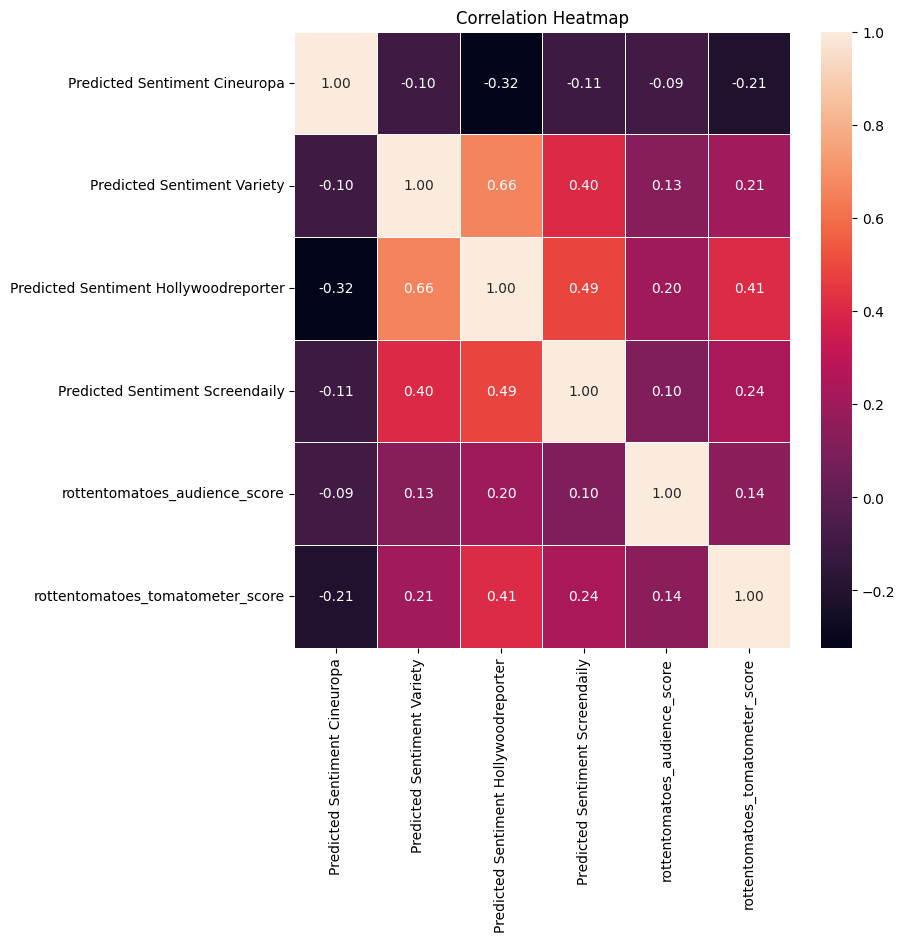

In [ ]:
correlation_matrix = merged_data.corr(numeric_only=True)

# Create a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="rocket", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show();

In [ ]:
data_all.columns

Index(['text', 'Predicted Sentiment Cineuropa',
       'Sentiment (Probabilities) Cineuropa', 'text',
       'Predicted Sentiment Variety', 'Sentiment (Probabilities) Variety',
       'text', 'Predicted Sentiment Hollywoodreporter',
       'Sentiment (Probabilities) Hollywoodreporter', 'text',
       'Predicted Sentiment Screendaily',
       'Sentiment (Probabilities) Screendaily', 'ID', 'url', 'title',
       'original_title', 'director', 'year', 'country',
       'cineuropa_review_author', 'cineuropa_review_text',
       'cineuropa_review_date', 'variety_review_author', 'variety_review_text',
       'variety_review_date', 'hollywoodreporter_review_author',
       'hollywoodreporter_review_text', 'hollywoodreporter_review_date',
       'screendaily_review_author', 'screendaily_review_text',
       'screendaily_review_date', 'rottentomatoes_tomatometer_score',
       'rottentomatoes_audience_score', 'cineuropa_quarter', 'variety_quarter',
       'hollywoodreporter_quarter', 'screendail

In [ ]:
master = data_all[['title',
           'original_title',
           'director',
           'country',
           'year',
           'cineuropa_review_date',
           'Predicted Sentiment Cineuropa',
           'Sentiment (Probabilities) Cineuropa',
           'variety_review_date',
           'Predicted Sentiment Variety',
           'Sentiment (Probabilities) Variety',
           'hollywoodreporter_review_date',
           'Predicted Sentiment Hollywoodreporter',
           'Sentiment (Probabilities) Hollywoodreporter',
           'screendaily_review_date',
           'Predicted Sentiment Screendaily',
           'Sentiment (Probabilities) Screendaily',
           'rottentomatoes_tomatometer_score',
           'rottentomatoes_audience_score']]

In [ ]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5760 entries, 0 to 5759
Data columns (total 19 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   title                                        5760 non-null   object        
 1   original_title                               5760 non-null   object        
 2   director                                     5760 non-null   object        
 3   country                                      5760 non-null   object        
 4   year                                         5760 non-null   int64         
 5   cineuropa_review_date                        5760 non-null   datetime64[ns]
 6   Predicted Sentiment Cineuropa                5760 non-null   float64       
 7   Sentiment (Probabilities) Cineuropa          5760 non-null   object        
 8   variety_review_date                          2082 non-null   datetime64[ns]
 9

In [ ]:
master.to_csv(path+'Sentiment_Master_27122023.csv', index=False)

In [ ]:
master_new = pd.read_csv(path+'Sentiment_Master_27122023.csv')
master_new

,title,original_title,director,country,cineuropa_review_date,Predicted Sentiment Cineuropa,Sentiment (Probabilities) Cineuropa,variety_review_date,Predicted Sentiment Variety,Sentiment (Probabilities) Variety,hollywoodreporter_review_date,Predicted Sentiment Hollywoodreporter,Sentiment (Probabilities) Hollywoodreporter,screendaily_review_date,Predicted Sentiment Screendaily,Sentiment (Probabilities) Screendaily,rottentomatoes_tomatometer_score,rottentomatoes_audience_score
0,The Innocent,L'Innocent,Louis Garrel,France,2022-10-11,1.0,"[0.00106498, 0.99893504]",NaN,NaN,NaN,NaN,NaN,NaN,2022-05-25,0.0,[0.9986016 0.00139836],NaN,NaN
1,Venus,Venus,Jaume Balagueró,Spain,2022-10-11,1.0,"[0.00109326, 0.99890673]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Eagles from Țaga,Vulturii din Țaga,"Iulian Manuel Ghervas, Adina Popescu","Romania, Slovakia",2022-10-10,1.0,"[0.0012359, 0.99876416]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Amazing Elisa,Asombrosa Elisa,Sadrac González-Perellón,Spain,2022-10-07,0.0,"[0.9978123, 0.00218765]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Roald Dahl's Matilda the Musical,Roald Dahl's Matilda the Musical,Matthew Warchus,"United Kingdom, United States",2022-10-07,1.0,"[0.00350507, 0.99649495]",2022-10-05,1.0,[0.00142502 0.998575 ],NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,Live and Become,"Va, vis et deviens",Radu Mihaileanu,"France, Italy, Israel, Belgium",2005-04-06,1.0,"[0.00112253, 0.99887747]",2005-02-14,1.0,[0.00181265 0.99818736],NaN,NaN,NaN,2005-03-30,0.0,[0.99174786 0.0082522 ],88.0,93.0
5756,I Like to Work (Mobbing),Mi piace lavorare,Francesca Comencini,Italy,2005-03-23,1.0,"[0.00117707, 0.99882287]",2004-02-22,1.0,[0.00192485 0.9980751 ],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5757,ANDRE VALENTE,ANDRE VALENTE,Catarina Ruivo,Portugal,2005-03-16,1.0,"[0.00140059, 0.99859947]",2004-08-17,1.0,[0.00126082 0.9987392 ],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5758,Hotel Rwanda,Hotel Rwanda,Terry George,"United Kingdom, Canada, Italy, Saudi Arabia",2005-03-16,1.0,"[0.00107876, 0.9989213]",2004-09-15,0.0,[9.9935561 6.4434664],NaN,NaN,NaN,2004-09-20,1.0,[0.0011209 0.99887913],91.0,94.0


# Manual Verification of Anchor Words (alibi)

In [ ]:
!pip install spacy
!pip install alibi

import spacy
import string
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from alibi.explainers import AnchorText
from alibi.datasets import fetch_movie_sentiment
from alibi.utils import spacy_model
from alibi.utils import DistilbertBaseUncased, BertBaseUncased, RobertaBase

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
def find_sentiment_reviews(text):



    predicted_values = predict_sentiment(model, tokenizer, text)
    return list(zip(text, predicted_values))

In [ ]:
data[4]


'a visually flashy but narratively opaque and emotionally vapid exercise in style and mystification .'

In [ ]:
text = 'I like it'
find_sentiment_reviews(text)

('I', array([1, 1, 0, 0, 0, 1, 1, 0, 0]))

In [ ]:
movies = fetch_movie_sentiment()
movies.keys()
data = movies.data
labels = movies.target
target_names = movies.target_names

In [ ]:
class_names = movies.target_names

# select instance to be explained
text = data[4]
print("* Text: %s" % text)

# compute class prediction
find_sentiment_reviews(text)

* Text: a visually flashy but narratively opaque and emotionally vapid exercise in style and mystification .


('a',
 array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]))

In [ ]:
explainer = AnchorText(
    predictor=predict_fn,
    sampling_strategy='unknown',
    nlp=nlp,
)

In [ ]:
explanation = explainer.explain(text, threshold=0.95)

In [ ]:
 explanation.raw['examples']

[{'covered_true': array(['a UNK flashy UNK UNK opaque and emotionally vapid exercise in style UNK mystification .',
         'a UNK flashy UNK UNK UNK and emotionally UNK exercise UNK UNK and UNK UNK',
         'a UNK flashy UNK narratively opaque UNK UNK UNK exercise in style and UNK UNK',
         'UNK visually flashy UNK narratively UNK and emotionally UNK UNK UNK UNK UNK mystification .',
         'UNK UNK flashy UNK UNK opaque and emotionally UNK UNK in UNK and UNK .',
         'a visually flashy but UNK UNK and UNK UNK UNK in style UNK mystification .',
         'a visually flashy but UNK opaque UNK emotionally vapid UNK in UNK and mystification .',
         'a UNK flashy but narratively UNK UNK emotionally vapid exercise in style UNK mystification UNK',
         'a UNK flashy but narratively opaque UNK emotionally vapid exercise in style and mystification .',
         'a visually flashy UNK UNK opaque UNK UNK UNK exercise in UNK UNK UNK .'],
        dtype='<U199'),
  'covered_fa

In [ ]:
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('\nExamples where anchor applies and model predicts %s:' % pred)
print('\n'.join([x for x in explanation.raw['examples'][-1]['covered_true']]))
print('\nExamples where anchor applies and model predicts %s:' % alternative)
print('\n'.join([x for x in explanation.raw['examples'][-1]['covered_false']]))

Anchor: flashy
Precision: 0.99

Examples where anchor applies and model predicts negative:
a UNK flashy UNK UNK opaque and emotionally vapid exercise in style UNK mystification .
a UNK flashy UNK UNK UNK and emotionally UNK exercise UNK UNK and UNK UNK
a UNK flashy UNK narratively opaque UNK UNK UNK exercise in style and UNK UNK
UNK visually flashy UNK narratively UNK and emotionally UNK UNK UNK UNK UNK mystification .
UNK UNK flashy UNK UNK opaque and emotionally UNK UNK in UNK and UNK .
a visually flashy but UNK UNK and UNK UNK UNK in style UNK mystification .
a visually flashy but UNK opaque UNK emotionally vapid UNK in UNK and mystification .
a UNK flashy but narratively UNK UNK emotionally vapid exercise in style UNK mystification UNK
a UNK flashy but narratively opaque UNK emotionally vapid exercise in style and mystification .
a visually flashy UNK UNK opaque UNK UNK UNK exercise in UNK UNK UNK .

Examples where anchor applies and model predicts positive:
UNK UNK flashy but narr

In [ ]:
explainer = AnchorText(
    predictor=predict_fn,
    sampling_strategy='similarity',   # replace masked words by simialar words
    nlp=nlp,                          # spacy object
    sample_proba=0.5,                 # probability of a word to be masked and replace by as similar word
)

In [ ]:
explanation = explainer.explain(text, threshold=0.95)


In [ ]:
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('\nExamples where anchor applies and model predicts %s:' % pred)
print('\n'.join([x for x in explanation.raw['examples'][-1]['covered_true']]))
print('\nExamples where anchor applies and model predicts %s:' % alternative)
print('\n'.join([x for x in explanation.raw['examples'][-1]['covered_false']]))

Anchor: exercise AND vapid
Precision: 0.99

Examples where anchor applies and model predicts negative:
that visually flashy but tragically opaque and emotionally vapid exercise under genre and glorification .
another provably flashy but hysterically bulky and emotionally vapid exercise arounds style and authorization .
that- visually flashy but narratively opaque and politically vapid exercise in style and mystification .
a unintentionally decal but narratively thick and emotionally vapid exercise in unflattering and mystification .
the purposely flashy but narratively rosy and emotionally vapid exercise in style and mystification .
thievery intentionally flashy but hysterically gray and anally vapid exercise in style and mystification .
a irrationally flashy but narratively smoothness and purposefully vapid exercise near style and diction .
a medio flashy but narratively blue and economically vapid exercise since style and intuition .
a visually flashy but narratively opaque and anall

In [ ]:
explainer = AnchorText(
    predictor=predict_fn,
    sampling_strategy='similarity',  # replace masked words by simialar words
    nlp=nlp,                         # spacy object
    use_proba=True,                  # sample according to the similiary distribution
    sample_proba=0.5,                # probability of a word to be masked and replace by as similar word
    top_n=20,                        # consider only top 20 words most similar words
    temperature=0.2                  # higher temperature implies more randomness when sampling
)

In [ ]:
explanation = explainer.explain(text, threshold=0.95)


In [ ]:
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('\nExamples where anchor applies and model predicts %s:' % pred)
print('\n'.join([x for x in explanation.raw['examples'][-1]['covered_true']]))
print('\nExamples where anchor applies and model predicts %s:' % alternative)
print('\n'.join([x for x in explanation.raw['examples'][-1]['covered_false']]))

Anchor: exercise AND flashy
Precision: 1.00

Examples where anchor applies and model predicts negative:
a visually flashy but sarcastically brown and reflexively vapid exercise between style and mystification .
this visually flashy but intentionally shiny and emotionally vapid exercise in style and appropriation .
a visually flashy but narratively glossy and critically vapid exercise in accentuate and omission .
a visually flashy but historically glossy and purposely rapid exercise within stylesheet and equivocation .
each visually flashy but intently opaque and emotionally quickie exercise throughout style and mystification .
that reflexively flashy but narratively opaque and romantically melodramatic exercise within style and mystification .
a equally flashy but narratively boxy and emotionally predictable exercise in classism and exaggeration .
a visually flashy but narratively opaque and emotionally vapid exercise between style and mystification .
a visually flashy but emphatically

In [ ]:
new_df_parsed

,screendaily_review_text,year,screendaily_review_date,title,original_title,country,ID
0,\n\nSource: Wild Bunch International\n\n’The I...,2022,25/05/2022,The Innocent,L'Innocent,France,1
1,France.,2022,25/05/2022,The Innocent,L'Innocent,France,1
2,2022.,2022,25/05/2022,The Innocent,L'Innocent,France,1
3,99 mins.,2022,25/05/2022,The Innocent,L'Innocent,France,1
4,The crime-comedy-romance The Innocent stars di...,2022,25/05/2022,The Innocent,L'Innocent,France,1
...,...,...,...,...,...,...,...
49006,It is the historical tragedyand quiet bravery ...,2004,20/09/2004,Hotel Rwanda,Hotel Rwanda,"United Kingdom, Canada, Italy, Saudi Arabia",5901
49007,Georgealso chooses not to point fingers and ma...,2004,20/09/2004,Hotel Rwanda,Hotel Rwanda,"United Kingdom, Canada, Italy, Saudi Arabia",5901
49008,"Don Cheadle, in his firstlead, gives a solid p...",2004,20/09/2004,Hotel Rwanda,Hotel Rwanda,"United Kingdom, Canada, Italy, Saudi Arabia",5901
49009,"He is well supported bythe rest of the cast, w...",2004,20/09/2004,Hotel Rwanda,Hotel Rwanda,"United Kingdom, Canada, Italy, Saudi Arabia",5901


In [ ]:
data1 = new_df_parsed['screendaily_review_text'].astype(str).tolist()

# Print the resulting list
data1

['\n\nSource: Wild Bunch International\n\n’The Innocent’\n\nDir: Louis Garrel.',
 'France.',
 '2022.',
 '99 mins.',
 'The crime-comedy-romance\xa0The Innocent\xa0stars director Louis Garrel as a protective son who is worried about his mother marrying a career crook — only to discover that an occasional heist might actually bring some spice to his own life.',
 'This likeable, terribly contrived charmer is helped by a game cast that almost gets away clean, ultimately hampered by a script that impishly (but not always confidently) switches between tones.',
 'The Innocent\xa0is filled with goofy good cheer\n\nGarrel’s fourth feature screens Out of Competition at this year’s Cannes (it was the 75th anniversary special selection), where he’s also appearing in Valeria Bruni Tedeschi’s Competition entry\xa0Forever Young.',
 'He’s joined by Roschdy Zem, Noémie Merlant and Anouk Grinberg, and the film’s appealing date-night trappings should make it a solid theatrical performer.',
 '(The Innocent

# Manual Verification of Anchor Words LTP

In [3]:
pip install lit-nlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.9 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.8 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
r"""Demo for a sentiment analysis model with a custom frontend build.

This demo loads a small BERT model trained on a sentiment analysis task.
It also uses a custom frontend build, which has a fun potato module!

To run locally:
  python -m lit_nlp.examples.custom_module.potato_demo --port=5432

Once you see the ASCII-art LIT logo, navigate to localhost:5432 to access the
demo UI.
"""

from collections.abc import Sequence
import os
import pathlib
import sys
from typing import Optional

from absl import app
from absl import flags
from absl import logging

from lit_nlp import dev_server
from lit_nlp import server_flags
from lit_nlp.api import layout
from lit_nlp.examples.glue import data as glue_data
from lit_nlp.examples.glue import models as glue_models
from lit_nlp.lib import file_cache

# NOTE: additional flags defined in server_flags.py

FLAGS = flags.FLAGS
FLAGS.set_default("development_demo", True)
FLAGS.set_default("default_layout", "potato")

_MODEL = flags.DEFINE_string(
    "model",
    "https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz",
    "Path to model, as in examples/glue/demo.py")

# Use our custom frontend build from this directory.
FLAGS.set_default(
    "client_root",
    os.path.join(pathlib.Path(__file__).parent.absolute(), "build")
)


# Custom frontend layout; see api/layout.py
modules = layout.LitModuleName
POTATO_LAYOUT = layout.LitCanonicalLayout(
    upper={
        "Main": [modules.DatapointEditorModule, modules.ClassificationModule],
    },
    lower={
        "Data": [modules.DataTableModule, "potato-module"],
    },
    description="Custom layout with our spud-tastic potato module.",
)

CUSTOM_LAYOUTS = layout.DEFAULT_LAYOUTS | {"potato": POTATO_LAYOUT}


def get_wsgi_app() -> Optional[dev_server.LitServerType]:
  """Returns a LitApp instance for consumption by gunicorn."""
  FLAGS.set_default("server_type", "external")
  FLAGS.set_default("demo_mode", True)
  # Parse flags without calling app.run(main), to avoid conflict with
  # gunicorn command line flags.
  unused = flags.FLAGS(sys.argv, known_only=True)
  if unused:
    logging.info("potato_demo:get_wsgi_app() called with unused args: %s",
                 unused)
  return main([])


def main(argv: Sequence[str]) -> Optional[dev_server.LitServerType]:
  if len(argv) > 1:
    raise app.UsageError("Too many command-line arguments.")

  # Load our trained model.
  model = _MODEL.value
  if model.endswith(".tar.gz"):
    model = file_cache.cached_path(
        model, extract_compressed_file=True)

  models = {"sst": glue_models.SST2Model(model)}
  datasets = {"sst_dev": glue_data.SST2Data("validation")}

  # Start the LIT server. See server_flags.py for server options.
  lit_demo = dev_server.Server(
      models, datasets, layouts=CUSTOM_LAYOUTS, **server_flags.get_flags()
  )
  return lit_demo.serve()


if __name__ == "__main__":
  app.run(main)

NameError: name '__file__' is not defined